In [2]:
import os
import numpy as np
from scipy import misc
import sys
from random import shuffle
from random import uniform
import zipfile
from collections import OrderedDict
import glob
import time
from PIL import Image
from moviepy.editor import VideoFileClip
from tqdm import tqdm

%matplotlib inline
import matplotlib.pyplot as plt

In [3]:
gt_train_path = '/data2/cityscapes_dataset/gtFine/train'
imgs_train_path = '/data2/cityscapes_dataset/leftImg8bit/train'
gt_val_path = '/data2/cityscapes_dataset/gtFine/val'
imgs_val_path = '/data2/cityscapes_dataset/leftImg8bit/val'
gt_test_path = '/data2/cityscapes_dataset/gtFine/test'
imgs_test_path = '/data2/cityscapes_dataset/leftImg8bit/test'

In [12]:
# random image for unit tests
random_im_path = '/data2/cityscapes_dataset/leftImg8bit/train/jena/jena_000118_000019_leftImg8bit.png'
random_gt_path = '/data2/cityscapes_dataset/gtFine/train/jena/jena_000118_000019_gtFine_color.png'
random_instance_path = '/data2/cityscapes_dataset/gtFine/train/jena/jena_000118_000019_gtFine_instanceIds.png'
random_label_path = '/data2/cityscapes_dataset/gtFine/train/jena/jena_000118_000019_gtFine_labelIds.png'

In [4]:
# Get training data filenames
def get_files(imgs_dir, gt_dir):
    
    cities = os.listdir(imgs_dir)
    gt = []
    imgs = []
    for city in cities:
        new_gt_path = os.path.join(gt_dir, city)
        new_imgs_path = os.path.join(imgs_dir, city)
        gt += glob.glob(os.path.join(new_gt_path, "*labelIds.png"))
        imgs += glob.glob(os.path.join(new_imgs_path, "*.png"))
    imgs.sort()
    gt.sort()
    return imgs, gt

In [5]:
train_imgs, train_gt = get_files(imgs_train_path, gt_train_path)
val_imgs, val_gt = get_files(imgs_val_path, gt_val_path)
test_imgs, test_gt = get_files(imgs_test_path, gt_test_path)

In [6]:
def plot_image(image_path=None, img=None, from_path=True):
    if (from_path == True):
        img = misc.imread(image_path)
    if len(img.shape) == 4:
        img = np.squeeze(img)
    if img.dtype != np.uint8:
        img = img.astype(np.uint8)
    plt.imshow(img)
    plt.show()

In [7]:
# num_classes = 20, 19 objects classes plus one background glass

def prepare_ground_truth(img):
    
    # Five classes: road, side_walk, pedestrian, vehicles, others
    NUM_CLASSES = 20
    new_image = np.zeros((img.shape[0], img.shape[1], NUM_CLASSES))
    
    # (original_id)
    # road
    road_mask = img == 7
    # sidewalk 
    sidewalk_mask = img == 8
    
    building_mask = img == 11
    wall_mask = img == 12
    fence_mask = img == 13
    pole_mask = img == 17
    traffic_light_mask = img == 19
    traffic_sign_mask = img == 20
    vegetation_mask = img == 21
    terrain_mask = img == 22
    sky_mask = img == 23
    person_mask = img == 24
    rider_mask = img == 25
    car_mask = img == 26
    truck_mask = img == 27
    bus_mask = img == 28
    train_mask = img == 31
    motorcycle_mask = img == 32
    bicycle_mask = img == 33
    
    # everything else
    else_mask = np.logical_not(np.logical_or.reduce((road_mask, sidewalk_mask, building_mask, wall_mask,
                                                     fence_mask, pole_mask, traffic_light_mask, traffic_sign_mask,
                                                     vegetation_mask, terrain_mask, sky_mask, person_mask,
                                                     rider_mask, car_mask, truck_mask, bus_mask,
                                                     train_mask, motorcycle_mask, bicycle_mask)))


    new_image[:,:,0] = road_mask
    new_image[:,:,1] = sidewalk_mask
    new_image[:,:,2] = building_mask
    new_image[:,:,3] = wall_mask
    new_image[:,:,4] = fence_mask
    new_image[:,:,5] = pole_mask
    new_image[:,:,6] = traffic_light_mask
    new_image[:,:,7] = traffic_sign_mask
    new_image[:,:,8] = vegetation_mask
    new_image[:,:,9] = terrain_mask
    new_image[:,:,10] = sky_mask
    new_image[:,:,11] = person_mask
    new_image[:,:,12] = rider_mask
    new_image[:,:,13] = car_mask
    new_image[:,:,14] = truck_mask
    new_image[:,:,15] = bus_mask
    new_image[:,:,16] = train_mask
    new_image[:,:,17] = motorcycle_mask
    new_image[:,:,18] = bicycle_mask
    new_image[:,:,19] = else_mask
    
    return new_image.astype(np.float32)


In [8]:
def get_data(batch_size=1, num_classes=20, mode='train', imgs=train_imgs, gt=train_gt, im_size=500, no_crop=False):
    
    # Expects sorted lists of training images and ground truth as
    # 'data' and 'labels'
    if (mode == 'val'):
        imgs = val_imgs
        gt = val_gt
    elif (mode == 'test'):
        imgs = test_imgs
        gt = test_gt
    
    # get shape from any image
    shape_im = misc.imread(random_im_path)
    
    # Shuffle dataset
    if mode=='train':
        combined = list(zip(imgs, gt))
        shuffle(combined)
        imgs[:], gt[:] = zip(*combined)
    
    while(True):
        for i in range(0,len(imgs),batch_size):
            if (no_crop):
                images = np.empty((batch_size, shape_im.shape[0], shape_im.shape[1], shape_im.shape[2]))
                labels = np.empty((batch_size, shape_im.shape[0], shape_im.shape[1], num_classes))
                for j, img in enumerate(imgs[i:i+batch_size]):
                    train_im = misc.imread(img).astype(np.float32)
                    images[j,:,:,:] = train_im
                    gt_im = misc.imread(gt[i+j])
                    labels[j,:,:,:] = prepare_ground_truth(gt_im)                   
            else:
                images = np.empty((batch_size, im_size, im_size, shape_im.shape[2]))
                labels = np.empty((batch_size, im_size, im_size, num_classes))
                for j, img in enumerate(imgs[i:i+batch_size]):
                    # Crop the size we want from a random spot in the image (as a form of
                    # minor data augmentation)
                    new_start_row = np.random.randint(0, shape_im.shape[0] - im_size)
                    new_start_col = np.random.randint(0, shape_im.shape[1] - im_size)
                    train_im = misc.imread(img).astype(np.float32)

                    train_im = train_im[new_start_row:new_start_row+im_size, new_start_col:new_start_col+im_size]
                    images[j,:,:,:] = train_im

                    gt_im = misc.imread(gt[i+j])
                    gt_im = gt_im[new_start_row:new_start_row+im_size, new_start_col:new_start_col+im_size]
                    labels[j,:,:,:] = prepare_ground_truth(gt_im)
            
            yield(images,labels)
            

In [10]:
# visualize_prediction for cityscape data
def visualize_prediction(original_image, prediction):
    
    original_image = np.squeeze(original_image).astype(np.uint8)
    new_image = np.copy(original_image)
    prediction = np.squeeze(prediction)
    mask = np.argmax(prediction, axis=2)
    # road = green
    # new_image[mask[:,:]==0, :] = [0,255,0]
    # sidewalk = blue
    #new_image[mask[:,:]==1, :] = [0,0,255]
    # pedestrians = yellow
    #new_image[mask[:,:]==2, :] = [255,255,0]
    # vehicles = red
    #new_image[mask[:,:]==3, :] = [255,0,0]
    # else is left the same
    
    new_image[mask[:,:]==0, :] = [128, 64, 128]
    new_image[mask[:,:]==1, :] = [244, 35, 232]
    new_image[mask[:,:]==2, :] = [70, 70, 70]
    new_image[mask[:,:]==3, :] = [102, 102, 156]
    new_image[mask[:,:]==4, :] = [190, 153, 153]
    new_image[mask[:,:]==5, :] = [153, 153, 153]
    new_image[mask[:,:]==6, :] = [250, 170, 30]
    new_image[mask[:,:]==7, :] = [220, 220,  0]
    new_image[mask[:,:]==8, :] = [107, 142, 35]
    new_image[mask[:,:]==9, :] = [128, 64, 128]
    new_image[mask[:,:]==10, :] = [152, 251, 152]
    new_image[mask[:,:]==11, :] = [220, 20, 60]
    new_image[mask[:,:]==12, :] = [255,  0,  0]
    new_image[mask[:,:]==13, :] = [0, 0, 142]
    new_image[mask[:,:]==14, :] = [0, 0, 70]
    new_image[mask[:,:]==15, :] = [0, 60, 100]
    new_image[mask[:,:]==16, :] = [0, 80, 100]
    new_image[mask[:,:]==17, :] = [0, 0, 230]
    new_image[mask[:,:]==18, :] = [119, 11, 32]
    new_image[mask[:,:]==19, :] = [128, 64, 128]
    
    new_image = Image.blend(Image.fromarray(original_image, mode='RGB').convert('RGBA'),
                            Image.fromarray(new_image, mode='RGB').convert('RGBA'),
                            alpha=0.5)
    
    plt.imshow(new_image, interpolation='nearest')
    plt.show()

In [14]:
val_gen_data = get_data(batch_size=1, num_classes=20, mode='val', imgs=val_imgs, gt=val_gt, no_crop=True)

In [15]:
val_images, val_labels =  next(val_gen_data)

In [16]:
type(val_images), type(val_labels)

(numpy.ndarray, numpy.ndarray)

In [17]:
val_images.shape, val_labels.shape

((1, 1024, 2048, 3), (1, 1024, 2048, 20))

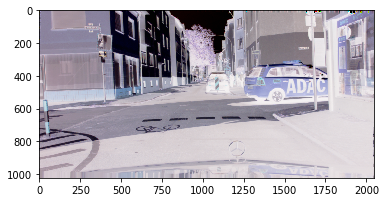

In [19]:
plt.imshow(val_images[0])

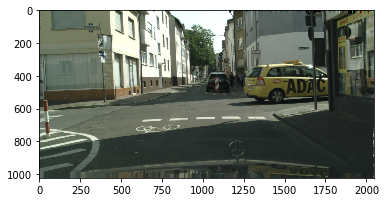

In [20]:
plot_image(img=val_images[0], from_path=False)

In [ ]:
prepped = prepare_ground_truth(val_labels[0])